'\n@author: jbrlod\nEND\n'

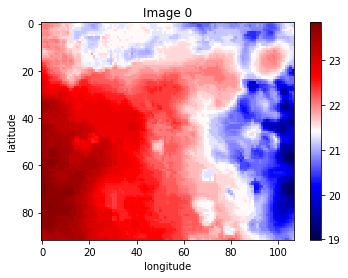

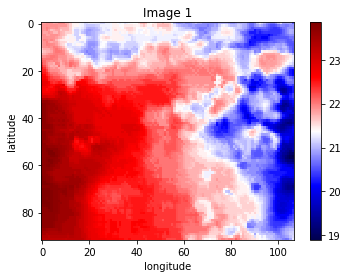

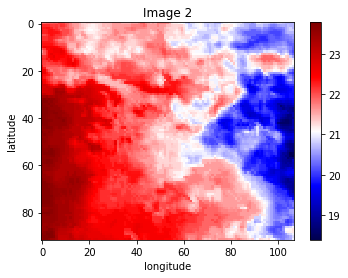

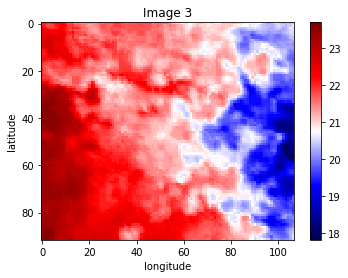

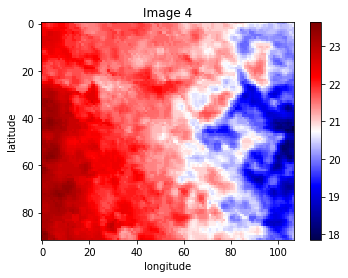

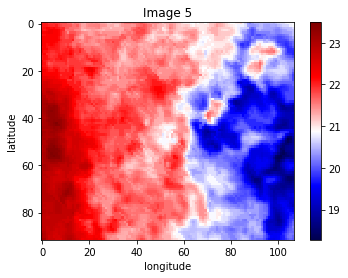

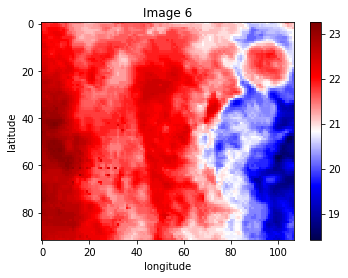

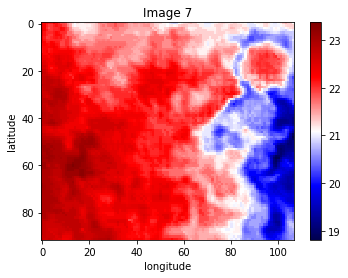

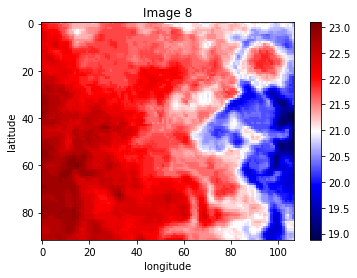

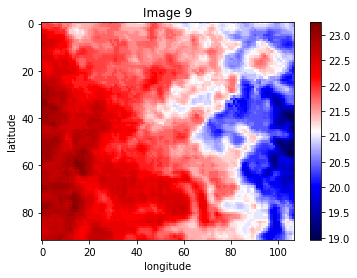

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# initial code given

"""
BEGINNING
Created on Thu Mar  1 13:55:00 2018
load base_hiver
@author: jbrlod
"""
import gzip
import pickle
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
%matplotlib inline
#Name of the base to load
fname = "base_hiver_2008.pklgz"

#image to plot
imind = 2

with gzip.open(fname,"rb") as fp:
    dictio = pickle.load(fp,encoding='latin1')



#SSTMW_in = dictio['CHLA']
SSTMW = dictio['SSTMW']
for imind in range(0,10): # plot all the images
    plt.figure()
    plt.imshow(SSTMW[imind],cmap='seismic')
    plt.colorbar()
    plt.title('Image ' + str(imind))
    plt.xlabel('longitude')
    plt.ylabel('latitude')

"""
@author: jbrlod
END
"""

In [2]:
# all libraries used and some additionals

from keras.layers import Input, Dense, Flatten, \
                            Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Reshape, merge
from keras.models import Model, Sequential
from keras import backend as K
from keras import losses
from keras.optimizers import Adam, RMSprop
from keras.models import Model
from keras.layers.convolutional import Conv2DTranspose,Conv2D
from keras.layers.core import Activation
from keras.layers import MaxPooling2D, concatenate, Input, LeakyReLU
from modelutil import masked_mse
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.callbacks import  EarlyStopping, Callback
from sklearn.model_selection import StratifiedKFold

from keras_adversarial.image_grid_callback import ImageGridCallback
from keras_adversarial import AdversarialModel, simple_gan, gan_targets
from keras_adversarial import normal_latent_sampling, AdversarialOptimizerSimultaneous
from keras_adversarial.legacy import l1l2, Dense, fit
from keras_adversarial import AdversarialModel, fix_names, n_choice
from keras_adversarial import AdversarialOptimizerSimultaneous, normal_latent_sampling
from modelutil import masked_mse

from keras.layers import Dense, Reshape, Flatten, Input, merge
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras_adversarial.legacy import l1l2
import keras.backend as K
import pandas as pd
import numpy as np
from keras_adversarial.image_grid_callback import ImageGridCallback
from keras.callbacks import TensorBoard
from keras.callbacks import History 
from keras_adversarial import AdversarialModel, fix_names, n_choice
from keras_adversarial import AdversarialOptimizerSimultaneous, normal_latent_sampling

from keras.layers import LeakyReLU, Activation
import os
import random
import pandas
import pylab
import math
import numpy.ma as ma
import random

/home/simon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def imreshape(image): # function extract 4 new images (64x64) for each image
    
    aux = image
    aux1 = aux[0:64,0:64]
    aux2 = aux[aux.shape[0]-65:aux.shape[0]-1,0:64]
    aux3 = aux[0:64,aux.shape[1]-65:aux.shape[1]-1]
    aux4 = aux[aux.shape[0]-65:aux.shape[0]-1,aux.shape[1]-65:aux.shape[1]-1]
    auxs = [aux1,aux2,aux3,aux4]
    return auxs


In [4]:
# reshape the new 64x64 images and triple it 344 --> 1032 images
sub_images = []
im_reshape = []
sub_images = [ imreshape(SSTMW[i]) for i in range(0,SSTMW.shape[0]) ] # implementation of the imreshape function
sub_images = np.asarray(sub_images)
sub_images = sub_images.reshape(86*4,64,64)
sub_images = np.concatenate((sub_images,sub_images,sub_images),axis=0)


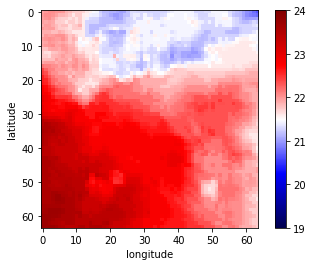

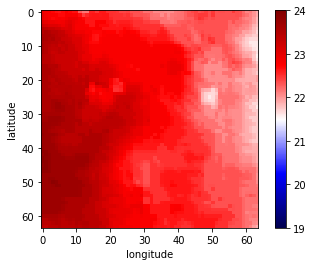

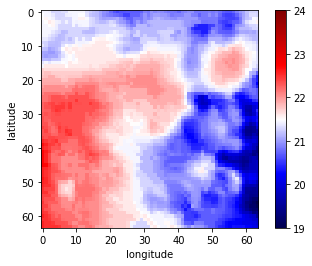

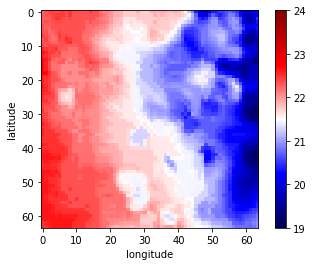

In [5]:
# examples of image after cut
for i in range(0,4):
    plt.figure()
    plt.imshow(sub_images[i],vmin=19,vmax=24,cmap='seismic')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.colorbar()

In [6]:
# artifitial holes generation on 64x64 image
def hole(image,size):
    aux = image.copy()
    a = random.randint(0,63)
    b = random.randint(0,63)
    aux[a:a+size[0],b:b+size[1]] = 0
    return aux

In [7]:
# used in loss function to consider surrounding pixels of missing parts
def nearby_hole(entree,distance):
    mask=np.zeros((64,64))
    for i in range(64):
        for j in range(64):
            if (entree[i,j]==0):
                for i2 in range(i-distance,i+distance+1):
                    for j2 in range(j-distance,j+distance+1):
                        if (i2>=0 and i2<entree.shape[0] and j2>=0 and j2<entree.shape[1]):
                            if(entree[i2,j2]!=0):
                                mask[i2,j2]=1
    return (mask)

# loss function
def penalized_loss(x,weight_hole=0.1,weight_ol=1):
    def loss(y_true, y_pred):
        zeronan = 0
        isMask_ol = nearby_hole(x,6)
        isMask_ol = K.cast(isMask_ol,dtype=K.floatx())
        isMask = K.equal(x,zeronan) # mask in the region with hole (integer)
        isMask_square = K.cast(isMask,dtype=K.floatx()) # mask for the pixel where the hole is
        isMask_out = 1 - isMask_square # mask  for the pixels not considering the hole
        loss_square = losses.mean_squared_error(y_true*isMask_square,y_pred*isMask_square)
        #loss_out = losses.mean_squared_error(y_true*isMask_out,y_pred*isMask_out)
        loss_ol = losses.mean_squared_error(y_true*isMask_ol,y_pred*isMask_ol)
        return loss_square*weight_hole  + loss_ol*weight_ol #  loss outputs sum
    return loss

In [8]:
# autoencoder model
def get_model():
    #mettre les inputs
    inputs = Input(shape=(64, 64, 1))
    #convolution classique
    conv_1 = Conv2D(20, (3, 3), strides=(1, 1), padding='same')(inputs)
    act_1 = Activation('relu')(conv_1)
    #pooling 64->32
    pl_1=MaxPooling2D((2, 2), strides=(2, 2))(act_1)
    #convolution classique2
    conv_2 = Conv2D(15, (3, 3), strides=(1, 1), padding='same')(pl_1)
    act_2 = Activation('relu')(conv_2)
    #pooling 32->16
    pl_2=MaxPooling2D((2, 2), strides=(2, 2))(act_2)
    #convolution classique3
    conv_3 = Conv2D(10, (3, 3), strides=(1, 1), padding='same')(pl_2)
    act_3 = Activation('relu')(conv_3)
    #pooling 16->8
    pl_3=MaxPooling2D((2, 2), strides=(2, 2))(act_3)
    #deconvolution classique
    deconv_1 = Conv2DTranspose(10, (3, 3), strides=(2, 2), padding='same')(pl_3)
    dact_1 = Activation('relu')(deconv_1)
    #ajouter en input de la couche d'entée
    merge_1 = concatenate([dact_1, act_3], axis=3)   
    #refaire une convolution avec les deux informations  
    deconv_2 = Conv2DTranspose(15, (3, 3), strides=(2, 2), padding='same')(merge_1)
    dact_2 = Activation('relu')(deconv_2)
    #ajouter en input de la couche d'entée
    merge_2 = concatenate([dact_2, act_2], axis=3)   
    #refaire une convolution avec les deux informations  
    deconv_3 = Conv2DTranspose(25, (3, 3), strides=(2, 2), padding='same')(merge_2)
    dact_3 = Activation('relu')(deconv_3)
    #ajouter en input de la couche d'entée
    merge_3 = concatenate([dact_3, inputs], axis=3)   
    #refaire une convolution avec les deux informations    
    final = Conv2D(1, (3, 3), strides=(1, 1), padding='same')(merge_3)
    dact_4 = Activation('relu')(final)

    model = Model(inputs=[inputs], outputs=[dact_4])
    model.compile(optimizer='adam', loss=penalized_loss(inputs))

    return model

In [9]:
# image normalization function
def image_norm(images):
    for a in range(0,images.shape[0]):
        images[a] = ( images[a]- images[a].mean() ) / images[a].std() + 3

In [10]:
# split dataset into training and test sets
xtrain_o, xtest_o, ytrain_o, ytest_o = train_test_split(sub_images, sub_images, test_size=0.2)
xtrain_o, xval_o, ytrain_o, yval_o = train_test_split(xtrain_o, ytrain_o, test_size=0.2)

In [11]:
im_ind = 7 # index for plotting example

# Single 10x10 artificial hole (autoencoder)

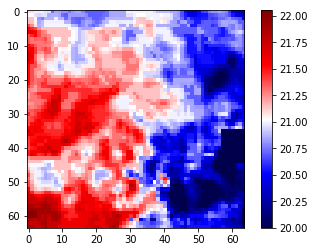

In [12]:
# artifitial 10x10 single hole generation on original images
train2 = []
for k in range(0,xtrain_o.shape[0]):
    holeim = hole(xtrain_o[k],(10,10))
    train2.append(holeim)
    
val2 = []
for k in range(0,xval_o.shape[0]):
    holeim = hole(xval_o[k],(10,10))
    val2.append(holeim)

test2 = []
for k in range(0,xtest_o.shape[0]):
    holeim = hole(xtest_o[k],(10,10))
    test2.append(holeim)
    
train2 = np.asarray(train2)
val2 = np.asarray(val2)
test2 = np.asarray(test2)

train2 = np.reshape(train2, (train2.shape[0], 64, 64))
val2 = np.reshape(val2, (val2.shape[0], 64, 64))
test2 = np.reshape(test2, (test2.shape[0], 64, 64))
train2[0][np.nonzero(train2[0])].std()

plt.imshow(test2[im_ind],vmin=20,cmap='seismic')
plt.colorbar()

(5.238015911991685, -44.463085695190756)

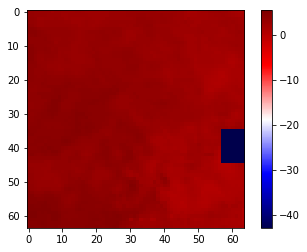

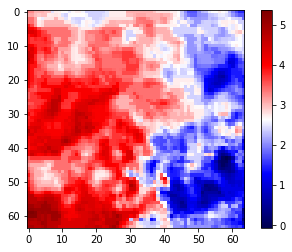

In [13]:
tr2 = np.ones(train2.shape)
vl2 = np.ones(val2.shape)
ts2 = np.ones(test2.shape)
try2 = np.ones(ytrain_o.shape)
vly2 = np.ones(yval_o.shape)
tsy2 = np.ones(ytest_o.shape)

for a in range(0,train2.shape[0]):
    tr2[a] = ( train2[a]- train2[a][np.nonzero(train2[a])].mean() ) \
        / train2[a][np.nonzero(train2[a])].std() + 3
    
for b in range(0,val2.shape[0]):
    vl2[b] = ( val2[b]- val2[b][np.nonzero(val2[b])].mean() ) \
    / val2[b][np.nonzero(val2[b])].std() + 3
    
for c in range(0,test2.shape[0]):
    ts2[c] = ( test2[c]- test2[c][np.nonzero(test2[c])].mean() ) \
    / test2[c][np.nonzero(test2[c])].std() + 3
    
for a in range(0,train2.shape[0]):
    try2[a] = ( ytrain_o[a]- train2[a][np.nonzero(train2[a])].mean() ) \
    / train2[a][np.nonzero(train2[a])].std() + 3
    
for b in range(0,val2.shape[0]):
    vly2[b] = ( yval_o[b]- val2[b][np.nonzero(val2[b])].mean() ) \
    / val2[b][np.nonzero(val2[b])].std() + 3 
    
for c in range(0,test2.shape[0]):
    tsy2[c] = ( ytest_o[c]- test2[c][np.nonzero(test2[c])].mean() ) \
    / test2[c][np.nonzero(test2[c])].std() + 3
    
# outputs normalized considering values of the non-empty zone 
tr2 = np.asarray(tr2)
vl2 = np.asarray(vl2)
ts2 = np.asarray(ts2)
try2 = np.asarray(try2)
vly2 = np.asarray(vly2)
tsy2 = np.asarray(tsy2)

plt.imshow(ts2[im_ind],cmap='seismic')
plt.colorbar()
plt.figure()
plt.imshow(tsy2[im_ind],cmap='seismic')
plt.colorbar()
ts2[0].max(),ts2[0].min()

In [14]:
# normalized image that will be the input of the netwok (holes with value of zero)
for a in range(0,tr2.shape[0]):
    tr2[a][train2[a] == 0] = 0
for b in range(0,vl2.shape[0]):
    vl2[b][val2[b,:,:] == 0]=0
for c in range(0,ts2.shape[0]):
    ts2[c][test2[c,:,:] == 0]=0

# image with holes in the normalized scale
tr2 = np.reshape(tr2, (tr2.shape[0], 64, 64, 1))
vl2 = np.reshape(vl2, (vl2.shape[0], 64, 64, 1))
ts2 = np.reshape(ts2, (ts2.shape[0], 64, 64, 1))
try2 = np.reshape(try2, (try2.shape[0], 64, 64, 1))
vly2 = np.reshape(vly2, (vly2.shape[0], 64, 64, 1))
tsy2 = np.reshape(tsy2, (tsy2.shape[0], 64, 64, 1))

In [15]:
# train the model for images with single hole
model2 = get_model()
#model2.summary()
cb = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')]
history2 = model2.fit(tr2,try2,epochs=1,validation_data=(vl2,vly2),batch_size=5,callbacks=cb)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 660 samples, validate on 165 samples
Epoch 1/1
660/660 [==============================] - 32s 48ms/step - loss: 0.0030 - val_loss: 5.9026e-04


In [ ]:
model2.save('autoencoder_single_hole')
#model2 = load_model('autoencoder_single_hole',custom_objects={'penalized_loss':penalized_loss})

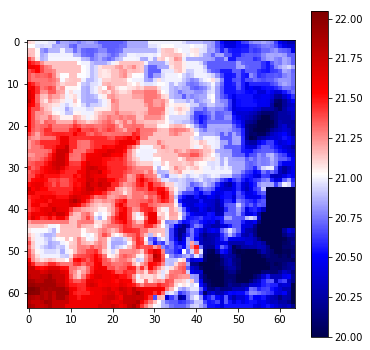

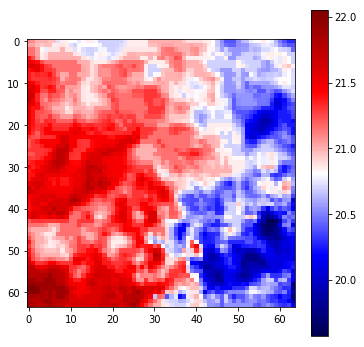

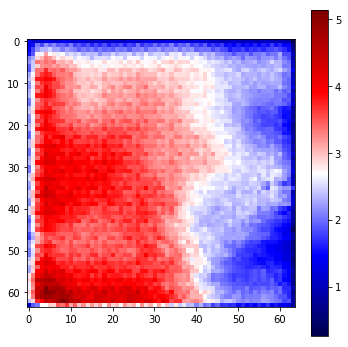

In [17]:
# prediction
decoded_imgs2 = model2.predict(ts2)

decoded_imgs2 = decoded_imgs2.reshape(decoded_imgs2.shape[0],64,64)

plt.figure(figsize=(6,6))
plt.imshow(test2[im_ind],vmin=20,cmap='seismic')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(ytest_o[im_ind],cmap='seismic')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs2[im_ind],cmap='seismic')
plt.colorbar()

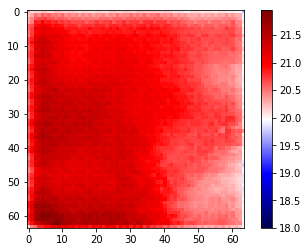

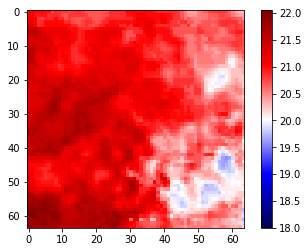

In [18]:
# prediction on real scale
decoded_imgs_orig2 = np.ones(decoded_imgs2.shape)

for index in range(0,decoded_imgs2.shape[0]):
    decoded_imgs_orig2[index] = (decoded_imgs2[index]-3)*test2[index][np.nonzero(test2[index])].std()+ \
                                    test2[index][np.nonzero(test2[index])].mean()
plt.figure()
plt.imshow(decoded_imgs_orig2[im_ind], vmin=18, cmap='seismic')
plt.colorbar()
plt.figure()
plt.imshow(ytest_o[im_ind], vmin=18, cmap='seismic')
plt.colorbar()

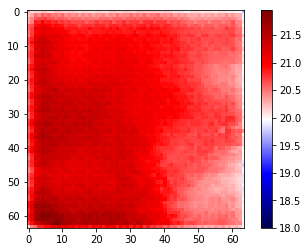

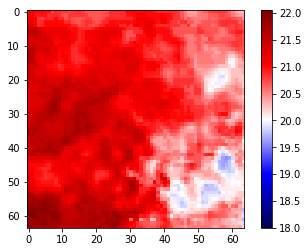

In [19]:
# inpainting using prediction only on missing values 
plt.imshow(decoded_imgs_orig2[im_ind],vmin=18,cmap='seismic')
plt.colorbar()
plt.figure()
plt.imshow(xtest_o[im_ind],vmin=18,cmap='seismic')
plt.colorbar()

inpainted2 = ts2.copy()
for n in range(0,decoded_imgs2.shape[0]):
    for a in range(0,64):
        for b in range(0,64):
            if inpainted2[n][a,b]==0:
                inpainted2[n][a,b]=decoded_imgs2[n][a,b]
                
inpainted2_orig = np.ones(inpainted2.shape)
for index in range(0,inpainted2.shape[0]):
    inpainted2_orig[index] = (inpainted2[index]-3)*test2[index][np.nonzero(test2[index])].std()+ \
                                    test2[index][np.nonzero(test2[index])].mean()
                
inpainted2_orig = inpainted2_orig.reshape(inpainted2_orig.shape[0],64,64)

# Multiple 6x6 holes (Autoencoder)

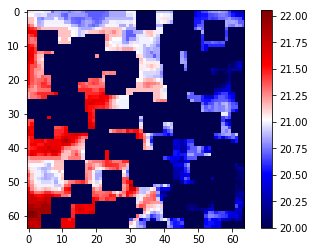

In [21]:
# artifitial 6x6 holes generation on original images
train3 = []
for k in range(0,xtrain_o.shape[0]):
    holeim = hole(xtrain_o[k],(2,2))
    for i in range(0,100):
        holeim = hole(holeim,(6,6))
    train3.append(holeim)
    
val3 = []
for k in range(0,xval_o.shape[0]):
    holeim = hole(xval_o[k],(2,2))
    for i in range(0,100):
        holeim = hole(holeim,(6,6))
    val3.append(holeim)

test3 = []
for k in range(0,xtest_o.shape[0]):
    holeim = hole(xtest_o[k],(2,2))
    for i in range(0,100):
        holeim = hole(holeim,(6,6))
    test3.append(holeim)
    
# training validation and test with real temp values
train3 = np.asarray(train3)
val3 = np.asarray(val3)
test3 = np.asarray(test3)

train3 = np.reshape(train3, (train3.shape[0], 64, 64))
val3 = np.reshape(val3, (val3.shape[0], 64, 64))
test3 = np.reshape(test3, (test3.shape[0], 64, 64))
train3[0][np.nonzero(train3[0])].std()

plt.imshow(test3[im_ind],vmin=20,cmap='seismic')
plt.colorbar()

(4.942711580660184, -42.96283430852574)

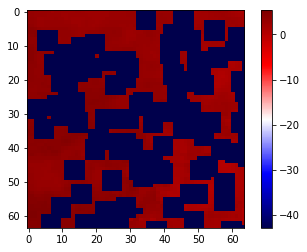

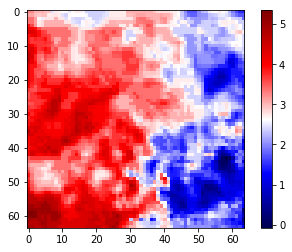

In [22]:
tr3 = np.ones(train3.shape)
vl3 = np.ones(val3.shape)
ts3 = np.ones(test3.shape)
try3 = np.ones(ytrain_o.shape)
vly3 = np.ones(yval_o.shape)
tsy3 = np.ones(ytest_o.shape)

for a in range(0,train3.shape[0]):
    tr3[a] = ( train3[a]- train3[a][np.nonzero(train3[a])].mean() ) \
        / train3[a][np.nonzero(train3[a])].std() + 3
    
for b in range(0,val3.shape[0]):
    vl3[b] = ( val3[b]- val3[b][np.nonzero(val3[b])].mean() ) \
    / val3[b][np.nonzero(val3[b])].std() + 3
    
for c in range(0,test3.shape[0]):
    ts3[c] = ( test3[c]- test3[c][np.nonzero(test3[c])].mean() ) \
    / test3[c][np.nonzero(test3[c])].std() + 3
    
for a in range(0,train3.shape[0]):
    try3[a] = ( ytrain_o[a]- train3[a][np.nonzero(train3[a])].mean() ) \
    / train3[a][np.nonzero(train3[a])].std() + 3
    
for b in range(0,val3.shape[0]):
    vly3[b] = ( yval_o[b]- val3[b][np.nonzero(val3[b])].mean() ) \
    / val3[b][np.nonzero(val3[b])].std() + 3 
    
for c in range(0,test3.shape[0]):
    tsy3[c] = ( ytest_o[c]- test3[c][np.nonzero(test3[c])].mean() ) \
    / test3[c][np.nonzero(test3[c])].std() + 3
    
# outputs normalized considering values of the non-empty zone 
tr3 = np.asarray(tr3)
vl3 = np.asarray(vl3)
ts3 = np.asarray(ts3)
try3 = np.asarray(try3)
vly3 = np.asarray(vly3)
tsy3 = np.asarray(tsy3)

tr3.min()

plt.imshow(ts3[im_ind],cmap='seismic')
plt.colorbar()
plt.figure()
plt.imshow(tsy3[im_ind],cmap='seismic')
plt.colorbar()
ts3[0].max(),ts3[0].min()

In [23]:
# holes with value of zero
for a in range(0,tr3.shape[0]):
    tr3[a][train3[a] == 0] = 0
for b in range(0,vl3.shape[0]):
    vl3[b][val3[b,:,:] == 0]=0
for c in range(0,ts3.shape[0]):
    ts3[c][test3[c,:,:] == 0]=0

# image with holes in the normalized scale
tr3 = np.reshape(tr3, (tr3.shape[0], 64, 64, 1))
vl3 = np.reshape(vl3, (vl3.shape[0], 64, 64, 1))
ts3 = np.reshape(ts3, (ts3.shape[0], 64, 64, 1))
try3 = np.reshape(try3, (try3.shape[0], 64, 64, 1))
vly3 = np.reshape(vly3, (vly3.shape[0], 64, 64, 1))
tsy3 = np.reshape(tsy3, (tsy3.shape[0], 64, 64, 1))

In [24]:
model3 =  get_model()
cbs = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')]
history3 = model3.fit(tr3,try3,validation_data=(vl3,vly3),epochs=1,batch_size=10,callbacks=cbs)

Train on 660 samples, validate on 165 samples
Epoch 1/1
660/660 [==============================] - 31s 47ms/step - loss: 0.1206 - val_loss: 0.0272


In [ ]:
model3.save('autoencoder_mult_hole')
#model3 = load_model('autoencoder_mult_hole',custom_objects={'penalized_loss':penalized_loss})

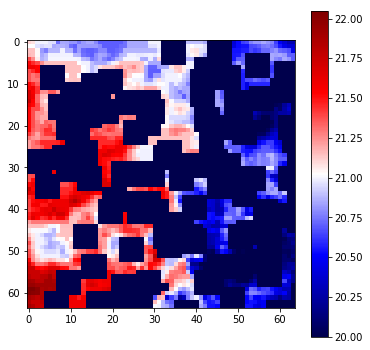

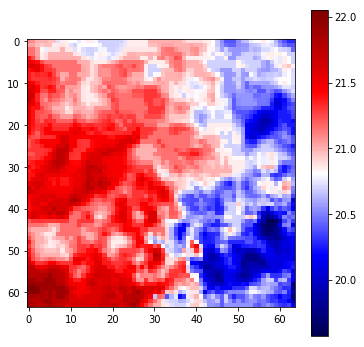

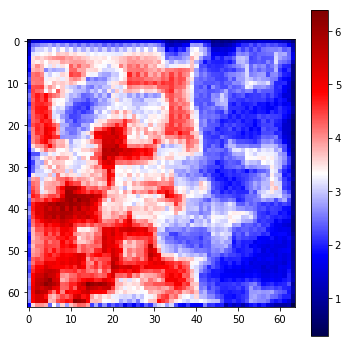

In [26]:
# prediction
decoded_imgs3 = model3.predict(ts3)

decoded_imgs3 = decoded_imgs3.reshape(decoded_imgs3.shape[0],64,64)

plt.figure(figsize=(6,6))
plt.imshow(test3[im_ind],vmin=20,cmap='seismic')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(ytest_o[im_ind],cmap='seismic')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs3[im_ind],cmap='seismic')
plt.colorbar()

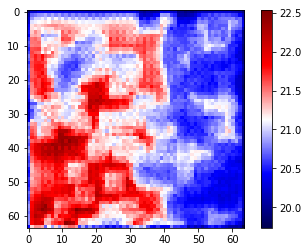

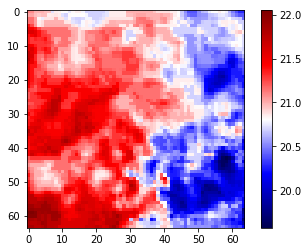

In [27]:
# prediction on real scale
decoded_imgs_orig3 = np.ones(decoded_imgs3.shape)

for index in range(0,decoded_imgs3.shape[0]):
    decoded_imgs_orig3[index] = (decoded_imgs3[index]-3)*test3[index][np.nonzero(test3[index])].std()+ \
                                    test3[index][np.nonzero(test3[index])].mean()
plt.figure()
plt.imshow(decoded_imgs_orig3[im_ind], cmap='seismic')
plt.colorbar()
plt.figure()
plt.imshow(ytest_o[im_ind], cmap='seismic')
plt.colorbar()

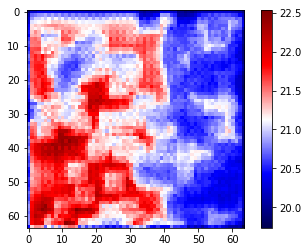

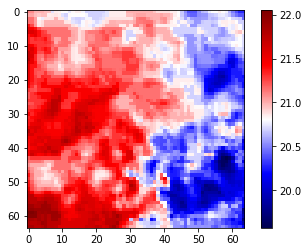

In [28]:
# inpainting of prediction only on missing values
plt.imshow(decoded_imgs_orig3[im_ind],cmap='seismic')
plt.colorbar()
plt.figure()
plt.imshow(xtest_o[im_ind],cmap='seismic')
plt.colorbar()

inpainted3 = ts3.copy()
for n in range(0,decoded_imgs3.shape[0]):
    for a in range(0,64):
        for b in range(0,64):
            if inpainted3[n][a,b]==0:
                inpainted3[n][a,b]=decoded_imgs3[n][a,b]
                
inpainted3_orig = np.ones(inpainted3.shape)
for index in range(0,inpainted3.shape[0]):
    inpainted3_orig[index] = (inpainted3[index]-3)*test3[index][np.nonzero(test3[index])].std()+ \
                                    test3[index][np.nonzero(test3[index])].mean()
                
inpainted3_orig = inpainted3_orig.reshape(inpainted3_orig.shape[0],64,64)

# Discriminator individual test

In [29]:
# random position of real and predicted images
outreal = []
for i in range(0,ytest_o.shape[0]):
    outreal.append(random.randint(0,1))
outreal = np.asarray(outreal)
outpred = 1 - outreal

gan_in = np.ones(ytest_o.shape[0]*2*64*64)
gan_in = np.reshape(gan_in,(ytest_o.shape[0],64,64,2))

for k in range(0,ytest_o.shape[0]-1):
    gan_in[k,:,:,outreal[k]] = ytest_o[k]
    gan_in[k,:,:,outpred[k]] = decoded_imgs_orig3[k]

In [30]:
# discriminator model
def get_discriminator():
    inputs = Input(shape=(64, 64,2))
    conv_1 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(inputs)
    act_1 = Activation('relu')(conv_1)
    pl_1=MaxPooling2D((2, 2), strides=(2, 2))(act_1)
    conv_2 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(pl_1)
    act_2 = Activation('relu')(conv_2)
    pl_2=MaxPooling2D((2, 2), strides=(2, 2))(act_2)
    conv_3 = Conv2D(8, (3, 3), strides=(1, 1), padding='same')(pl_2)
    act_3 = Activation('relu')(conv_3)
    pl_3=MaxPooling2D((2, 2), strides=(2, 2))(act_3)
    fc=Flatten()(pl_3)
    fc_2=Dense(40)(fc)
    act_4=Activation('relu')(fc_2)
    fc_3=Dense(25)(act_4)
    act_5=Activation('relu')(fc_3)
    fc_4=Dense(10)(act_5)
    act_6=Activation('relu')(fc_4)
    fc_5=Dense(1)(act_6)
    act_7=Activation('sigmoid')(fc_5)
    return Model(inputs,act_7)

In [31]:
xtr_discrim,xts_discrim,ytr_discrim,yts_discrim = train_test_split(gan_in,outreal,test_size=0.2)
#ytr = np.reshape(ytr,(62,))

In [33]:
# test discriminator individually
model4 = get_discriminator()
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model4.summary()
model4.fit(xtr_discrim,ytr_discrim,epochs=80,batch_size=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 2)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 32)        608       
_________________________________________________________________
activation_22 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 16)        4624      
_________________________________________________________________
activation_23 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 16)        0         
__________

KeyboardInterrupt: 

In [35]:
# performance on test set

#model4.save('discriminator_model')
#model4 = load_model('discriminator_model')

scores = model4.evaluate(xts_discrim,yts_discrim)
print("%s: %.2f%%" % (model4.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model4.metrics_names[1], scores[1]*100))

42/42 [==============================] - 1s 32ms/step
loss: 71.66%
acc: 35.71%


# GAN: autoencoder + discriminator

In [40]:
# GAN implementation functions definition

def model_discriminator():#latent_dim, output_dim=1, hidden_dim=512,reg=lambda: l1l2(1e-7, 1e-7)):
    
    inputs = Input(shape=(64, 64,2))
    conv_1 = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(inputs)
    act_1 = Activation('relu')(conv_1)
    pl_1=MaxPooling2D((2, 2), strides=(2, 2))(act_1)
    conv_2 = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(pl_1)
    act_2 = Activation('relu')(conv_2)
    pl_2=MaxPooling2D((2, 2), strides=(2, 2))(act_2)
    conv_3 = Conv2D(8, (3, 3), strides=(1, 1), padding='same')(pl_2)
    act_3 = Activation('relu')(conv_3)
    pl_3=MaxPooling2D((2, 2), strides=(2, 2))(act_3)
    fc=Flatten()(pl_3)
    fc_2=Dense(40)(fc)
    act_4=Activation('relu')(fc_2)
    fc_3=Dense(25)(act_4)
    act_5=Activation('relu')(fc_3)
    fc_4=Dense(10)(act_5)
    act_6=Activation('relu')(fc_4)
    fc_5=Dense(1)(act_6)
    act_7=Activation('sigmoid')(fc_5)
    return Model(inputs,act_7)

def model_autoencoder():
    #mettre les inputs
    inputs = Input(shape=(64, 64, 1))
    #convolution classique
    conv_1 = Conv2D(20, (3, 3), strides=(1, 1), padding='same')(inputs)
    act_1 = Activation('relu')(conv_1)
    #pooling 64->32
    pl_1=MaxPooling2D((2, 2), strides=(2, 2))(act_1)
    #convolution classique2
    conv_2 = Conv2D(15, (3, 3), strides=(1, 1), padding='same')(pl_1)
    act_2 = Activation('relu')(conv_2)
    #pooling 32->16
    pl_2=MaxPooling2D((2, 2), strides=(2, 2))(act_2)
    #convolution classique3
    conv_3 = Conv2D(10, (3, 3), strides=(1, 1), padding='same')(pl_2)
    act_3 = Activation('relu')(conv_3)
    #pooling 16->8
    pl_3=MaxPooling2D((2, 2), strides=(2, 2))(act_3)
    #deconvolution classique
    deconv_1 = Conv2DTranspose(10, (3, 3), strides=(2, 2), padding='same')(pl_3)
    dact_1 = Activation('relu')(deconv_1)
    #ajouter en input de la couche d'entée
    merge_1 = concatenate([dact_1, act_3], axis=3)   
    #refaire une convolution avec les deux informations  
    deconv_2 = Conv2DTranspose(15, (3, 3), strides=(2, 2), padding='same')(merge_1)
    dact_2 = Activation('relu')(deconv_2)
    #ajouter en input de la couche d'entée
    merge_2 = concatenate([dact_2, act_2], axis=3)   
    #refaire une convolution avec les deux informations  
    deconv_3 = Conv2DTranspose(25, (3, 3), strides=(2, 2), padding='same')(merge_2)
    dact_3 = Activation('relu')(deconv_3)
    #ajouter en input de la couche d'entée
    merge_3 = concatenate([dact_3, inputs], axis=3)   
    #refaire une convolution avec les deux informations    
    final = Conv2D(1, (3, 3), strides=(1, 1), padding='same')(merge_3)
    dact_4 = Activation('relu')(final)
    
    #model = Model(inputs=[inputs], outputs=[concatenate([inputs,dact_4],axis=3)])
    model = Model(inputs=[inputs], outputs=[dact_4])
    return model

# Single artificial 10x10 holes (GAN)

In [41]:
#def example_aae(path, adversarial_optimizer):
path = "output/aae"
adversarial_optimizer = AdversarialOptimizerSimultaneous()

# autoencoder (x -> x')
autoencoder = model_autoencoder()#Model(encoder.inputs, generator(encoder(encoder.inputs)))
# discriminator (z -> y)
discriminator = model_discriminator()#latent_dim)

# assemple AAE
x = autoencoder.inputs[0]
xpred = autoencoder(x)
yreal = discriminator(concatenate([x,xpred],axis=3))
aae = Model(x, fix_names([xpred, yreal], ["xpred", "yreal"]))

# print summary of models
autoencoder.summary()
discriminator.summary()

# build adversarial model
model5 = AdversarialModel(base_model=aae,
                         player_params=[autoencoder.trainable_weights, discriminator.trainable_weights],
                         player_names=["autoencoder", "discriminator"])
model5.adversarial_compile(adversarial_optimizer=adversarial_optimizer,
                          player_optimizers=['adam', Adam(1e-3, decay=1e-3)],
                          loss={"yreal": "binary_crossentropy",
                                "xpred": penalized_loss(x)},
                          player_compile_kwargs=[{"loss_weights": {"yreal": 1e-2, "xpred": 1}}] * 2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 64, 64, 20)   200         input_7[0][0]                    
__________________________________________________________________________________________________
activation_43 (Activation)      (None, 64, 64, 20)   0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 32, 32, 20)   0           activation_43[0][0]              
__________________________________________________________________________________________________
conv2d_23 

In [38]:
# train model with images having only one hole

n = tr2.shape[0] 
y = [try2, np.ones((n, 1)), try2, np.ones((n, 1))]
#y = [ytrain, np.ones((n, 1)), np.zeros((n, 1)), ytrain, np.zeros((n, 1)), np.ones((n, 1))]
ntest = ts2.shape[0]
nval = vl2.shape[0]
yvalid = [vly2, np.ones((nval, 1)), vly2, np.ones((nval, 1))]
yt = [tsy2, np.ones((ntest, 1)), tsy2, np.ones((ntest, 1))]

#ytest = [ytest, np.ones((ntest, 1)), np.zeros((ntest, 1)), ytest, np.zeros((ntest, 1)), np.ones((ntest, 1))]
es = [EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')]

history5 = model5.fit(x=tr2, y=y, validation_data=(vl2,yvalid),
                    nb_epoch=1, batch_size=10,callbacks=es)

/home/simon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 660 samples, validate on 165 samples
Epoch 1/1
660/660 [==============================] - 47s 71ms/step - loss: 0.0074 - autoencoder_loss: 0.0037 - autoencoder_xpred_loss: 0.0035 - autoencoder_yreal_loss: 0.0206 - discriminator_loss: 0.0037 - discriminator_xpred_loss: 0.0035 - discriminator_yreal_loss: 0.0206 - val_loss: 0.0026 - val_autoencoder_loss: 0.0013 - val_autoencoder_xpred_loss: 0.0013 - val_autoencoder_yreal_loss: 1.1921e-07 - val_discriminator_loss: 0.0013 - val_discriminator_xpred_loss: 0.0013 - val_discriminator_yreal_loss: 1.1921e-07


In [ ]:
#autoencoder.save(os.path.join(path,"autoencoder1hole.h5")) #autoencodernholes.h5
#generator.save(os.path.join(path, "generator1hole.h5")) #generatornholes.h5

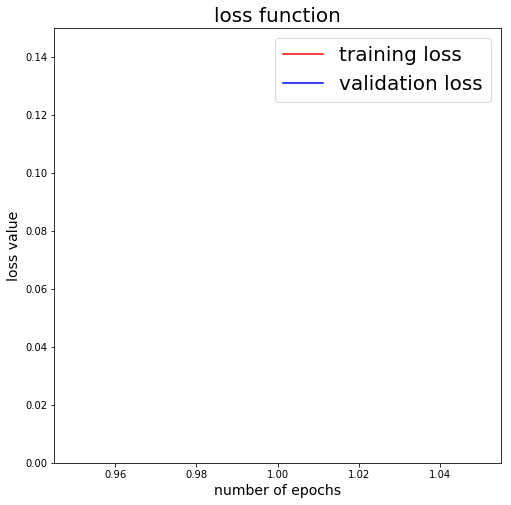

In [42]:
# loss on training and validation sets
trloss = history5.history['loss']
trloss = np.asarray(trloss)
vloss = history5.history['val_loss']
vloss = np.asarray(vloss)
ep = np.linspace(1,vloss.shape[0],vloss.shape[0])

plt.figure(figsize=(8,8))
plt.plot(ep,trloss,'r',label='training loss')
plt.plot(ep,vloss,'b',label='validation loss')
plt.ylim([0, 0.15])
plt.title('loss function',fontsize=20)
plt.xlabel('number of epochs',fontsize=14)
plt.ylabel('loss value',fontsize=14)
plt.legend(fontsize=20)

(207, 64, 64, 1)


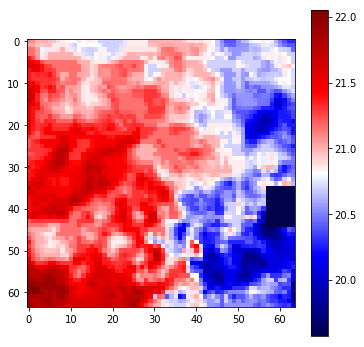

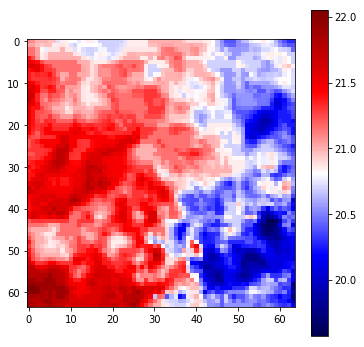

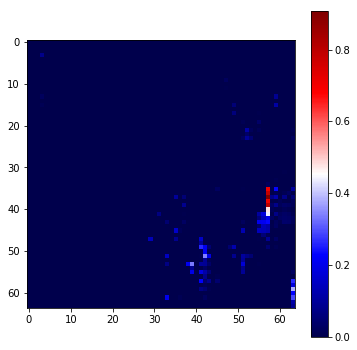

In [43]:
# prediction
#decoded_imgs = autoencoder.predict(xtest3)
decoded_imgs5 = model5.predict(ts2)
decoded_imgs5 = np.asarray(decoded_imgs5[0])
print(decoded_imgs5.shape)

decoded_imgs5 = decoded_imgs5.reshape(decoded_imgs5.shape[0],64,64)

plt.figure(figsize=(6,6))
plt.imshow(test2[im_ind],vmin=ytest_o[im_ind].min(),cmap='seismic')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(ytest_o[im_ind],cmap='seismic')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs5[im_ind],cmap='seismic')
plt.colorbar()

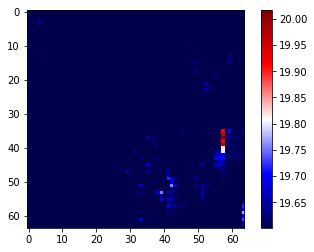

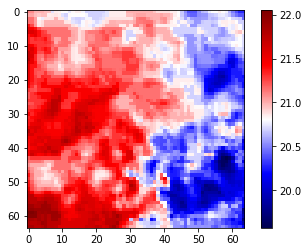

In [44]:
# prediction on real scale
decoded_imgs_orig5 = np.ones(decoded_imgs5.shape)

for index in range(0,decoded_imgs5.shape[0]):
    decoded_imgs_orig5[index] = (decoded_imgs5[index]-3)*test2[index][np.nonzero(test2[index])].std()+ \
                                    test2[index][np.nonzero(test2[index])].mean()
plt.figure()
plt.imshow(decoded_imgs_orig5[im_ind], cmap='seismic')
plt.colorbar()
plt.figure()
plt.imshow(ytest_o[im_ind], cmap='seismic')
plt.colorbar()

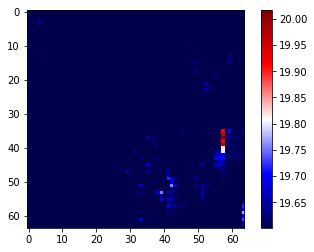

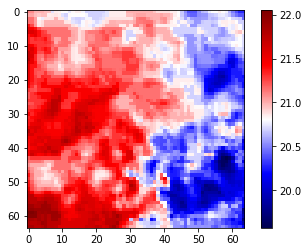

In [45]:
# inpainting of predicted values only on missing regions
plt.imshow(decoded_imgs_orig5[im_ind],cmap='seismic')
plt.colorbar()
plt.figure()
plt.imshow(xtest_o[im_ind],cmap='seismic')
plt.colorbar()

inpainted2_gan= ts2.copy()
for n in range(0,decoded_imgs5.shape[0]):
    for a in range(0,64):
        for b in range(0,64):
            if inpainted2_gan[n][a,b]==0:
                inpainted2_gan[n][a,b]=decoded_imgs5[n][a,b]
                
inpainted2_gan_orig = np.ones(inpainted2_gan.shape)
for index in range(0,inpainted2_gan.shape[0]):
    inpainted2_gan_orig[index] = (inpainted2_gan[index]-3)*test2[index][np.nonzero(test2[index])].std()+ \
                                    test2[index][np.nonzero(test2[index])].mean()
                
inpainted2_gan_orig = inpainted2_gan_orig.reshape(inpainted2_gan_orig.shape[0],64,64)

# Multiple 6x6 holes (GAN)

In [46]:
# model compilation
model6 = AdversarialModel(base_model=aae,
                         player_params=[autoencoder.trainable_weights, discriminator.trainable_weights],
                         player_names=["autoencoder", "discriminator"])
model6.adversarial_compile(adversarial_optimizer=adversarial_optimizer,
                          player_optimizers=['adam', Adam(1e-3, decay=1e-3)],
                          loss={"yreal": "binary_crossentropy",
                                "xpred": penalized_loss(x)},
                          player_compile_kwargs=[{"loss_weights": {"yreal": 1e-2, "xpred": 1}}] * 2)

In [47]:
# train model with images having multiple hole

n = tr3.shape[0] 
y = [try3, np.ones((n, 1)), try3, np.ones((n, 1))]
#y = [ytrain, np.ones((n, 1)), np.zeros((n, 1)), ytrain, np.zeros((n, 1)), np.ones((n, 1))]
ntest = ts3.shape[0]
nval = vl3.shape[0]
yvalid = [vly3, np.ones((nval, 1)), vly3, np.ones((nval, 1))]
yt = [tsy3, np.ones((ntest, 1)), tsy3, np.ones((ntest, 1))]

#ytest = [ytest, np.ones((ntest, 1)), np.zeros((ntest, 1)), ytest, np.zeros((ntest, 1)), np.ones((ntest, 1))]
es = [EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')]

history6 = model6.fit(x=tr3, y=y, validation_data=(vl3,yvalid),
                    nb_epoch=1, batch_size=10,callbacks=es)

/home/simon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 660 samples, validate on 165 samples
Epoch 1/1
660/660 [==============================] - 58s 89ms/step - loss: 0.2142 - autoencoder_loss: 0.1071 - autoencoder_xpred_loss: 0.1068 - autoencoder_yreal_loss: 0.0249 - discriminator_loss: 0.1071 - discriminator_xpred_loss: 0.1068 - discriminator_yreal_loss: 0.0249 - val_loss: 0.0496 - val_autoencoder_loss: 0.0248 - val_autoencoder_xpred_loss: 0.0248 - val_autoencoder_yreal_loss: 1.1921e-07 - val_discriminator_loss: 0.0248 - val_discriminator_xpred_loss: 0.0248 - val_discriminator_yreal_loss: 1.1921e-07


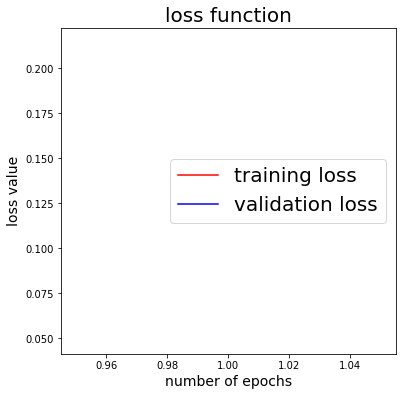

In [48]:
# loss function on training and validation set
trloss2 = history6.history['loss']
trloss2 = np.asarray(trloss2)
vloss2 = history6.history['val_loss']
vloss2 = np.asarray(vloss2)
ep2 = np.linspace(1,vloss2.shape[0],vloss2.shape[0])

plt.figure(figsize=(6,6))
plt.plot(ep2,trloss2,'r',label='training loss')
plt.plot(ep2,vloss2,'b',label='validation loss')
plt.title('loss function',fontsize=20)
plt.xlabel('number of epochs',fontsize=14)
plt.ylabel('loss value',fontsize=14)
plt.legend(fontsize=20)


In [78]:
#autoencoder.save(os.path.join(path,"autoencodernholes.h5")) 
#generator.save(os.path.join(path, "generatornholes.h5")) 

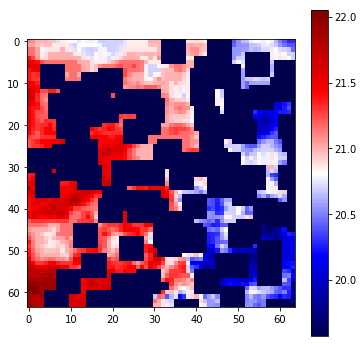

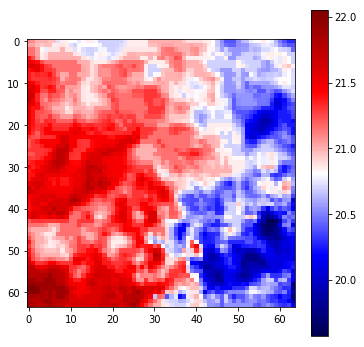

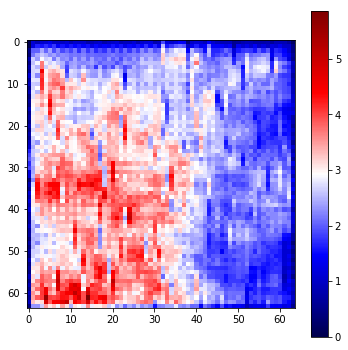

In [49]:
# prediction

#decoded_imgs = autoencoder.predict(xtest3)
decoded_imgs6 = model6.predict(ts3)
decoded_imgs6 = np.asarray(decoded_imgs6[0])
decoded_imgs6 = decoded_imgs6.reshape(decoded_imgs6.shape[0],64,64)

plt.figure(figsize=(6,6))
plt.imshow(test3[im_ind],vmin=ytest_o[im_ind].min(),cmap='seismic')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(ytest_o[im_ind],cmap='seismic')
plt.colorbar()

plt.figure(figsize=(6,6))
plt.imshow(decoded_imgs6[im_ind],cmap='seismic')
plt.colorbar()

In [50]:
# prediction on original scale
decoded_imgs_orig6 = np.ones(decoded_imgs6.shape)

for index in range(0,decoded_imgs6.shape[0]):
    decoded_imgs_orig6[index] = (decoded_imgs6[index]-3)*test3[index][np.nonzero(test3[index])].std()+ \
                                    test3[index][np.nonzero(test3[index])].mean()

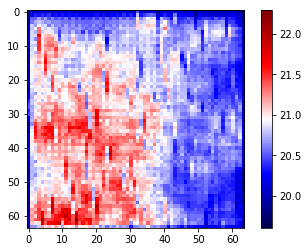

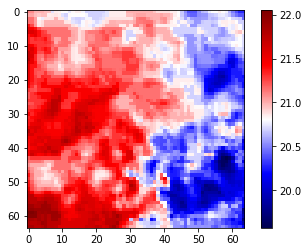

In [51]:
# inpainting of prediction only on missing values
plt.imshow(decoded_imgs_orig6[im_ind],cmap='seismic')
plt.colorbar()
plt.figure()
plt.imshow(xtest_o[im_ind],cmap='seismic')
plt.colorbar()

inpainted3_gan= ts3.copy()
for n in range(0,decoded_imgs6.shape[0]):
    for a in range(0,64):
        for b in range(0,64):
            if inpainted3_gan[n][a,b]==0:
                inpainted3_gan[n][a,b]=decoded_imgs6[n][a,b]
                
inpainted3_gan_orig = np.ones(inpainted3_gan.shape)
for index in range(0,inpainted3_gan.shape[0]):
    inpainted3_gan_orig[index] = (inpainted3_gan[index]-3)*test3[index][np.nonzero(test3[index])].std()+ \
                                    test3[index][np.nonzero(test3[index])].mean()
                
inpainted3_gan_orig = inpainted3_gan_orig.reshape(inpainted3_gan_orig.shape[0],64,64)

# RMSE

In [52]:
# rmse in zone without holes (single hole)
rmse5_without = []
for index in range(0,test3.shape[0]):
    rmse_indiv = math.sqrt(np.sum((decoded_imgs_orig5[index][np.nonzero(test3[index])] - \
                     xtest_o[index][np.nonzero(test3[index])])**2)/(np.asarray(np.nonzero(test3[index])).shape[0]*np.asarray(np.nonzero(test3[index])).shape[1]))
    rmse5_without.append(rmse_indiv)
rmse5_without = np.asarray(rmse5_without)
rmse5_without.mean()

1.30404702315087

In [53]:
# rmse in zone with holes (single hole)
rmse5_with = []
for index in range(0,test3.shape[0]):
    rmse_indiv = math.sqrt(np.sum((decoded_imgs_orig5[index][np.where(test3[index]==0)] - \
                     xtest_o[index][np.where(test3[index]==0)])**2)/(np.asarray(np.where(test3[index]==0)).shape[0]*np.asarray(np.where(test3[index]==0)).shape[1]))
    rmse5_with.append(rmse_indiv)
rmse5_with = np.asarray(rmse5_with)
rmse5_with.mean()

1.2865455734089288

In [54]:
# rmse of the total image (single hole)
rmse5_with = []
for index in range(0,test3.shape[0]):
    rmse_indiv = math.sqrt(np.sum((decoded_imgs_orig5[index] - \
                     xtest_o[index])**2)/(64*64))
    rmse5_with.append(rmse_indiv)
rmse5_with = np.asarray(rmse5_with)
rmse5_with.mean()

1.8312861590694884

In [55]:
# rmse in zone without holes (mult hole)
rmse6_without = []
for index in range(0,test3.shape[0]):
    rmse_indiv = math.sqrt(np.sum((decoded_imgs_orig6[index][np.nonzero(test3[index])] - \
                     xtest_o[index][np.nonzero(test3[index])])**2)/(np.asarray(np.nonzero(test3[index])).shape[0]*np.asarray(np.nonzero(test3[index])).shape[1]))
    rmse6_without.append(rmse_indiv)
rmse6_without = np.asarray(rmse6_without)
rmse6_without.mean()

0.41986305927723905

In [56]:
# rmse in zones with holes (mult hole)
rmse6_with = []
for index in range(0,test3.shape[0]):
    rmse_indiv = math.sqrt(np.sum((decoded_imgs_orig6[index][np.where(test3[index]==0)] - \
                     xtest_o[index][np.where(test3[index]==0)])**2)/(np.asarray(np.where(test3[index]==0)).shape[0]*np.asarray(np.where(test3[index]==0)).shape[1]))
    rmse6_with.append(rmse_indiv)
rmse6_with = np.asarray(rmse6_with)
rmse6_with.mean()

0.27258851455960253

In [57]:
# rmse of the total image (mult hole)
rmse6_tot = []
for index in range(0,test3.shape[0]):
    rmse_indiv = math.sqrt(np.sum((decoded_imgs_orig6[index] - \
                     xtest_o[index])**2)/(64*64))
    rmse6_tot.append(rmse_indiv)
rmse6_tot = np.asarray(rmse6_tot)
rmse6_tot.mean()

0.4914590575935235

# Image difference

In [58]:
# image diff between y_pred and y_real for each of the aforementioned cases
imdiff_1hole1 = decoded_imgs_orig2 - ytest_o # y_pred - y_real single hole real scale (only autoencoder)
imdiff_nhole1 = decoded_imgs_orig3 - ytest_o # y_pred - y_real mult holes real scale (only autoencoder)
imdiff_1hole12 = inpainted2_orig - ytest_o # y_inpaint - y_real single hole real scale (only autoencoder)
imdiff_nhole12 = inpainted3_orig - ytest_o # y_inpaint - y_real mult holes real scale (only autoencoder)

imdiff_1hole2 = decoded_imgs_orig5 - ytest_o # y_pred - y_real single hole real scale (GAN)
imdiff_nhole2 = decoded_imgs_orig6 - ytest_o # y_pred - y_real mult holes real scale (GAN)
imdiff_1hole22 = inpainted2_gan_orig - ytest_o # y_inpaint - y_real single hole real scale (GAN)
imdiff_nhole22 = inpainted3_gan_orig - ytest_o # y_inpaint - y_real mult holes real scale (GAN)

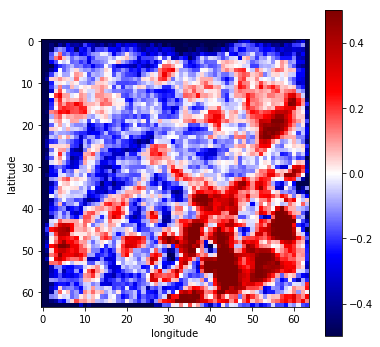

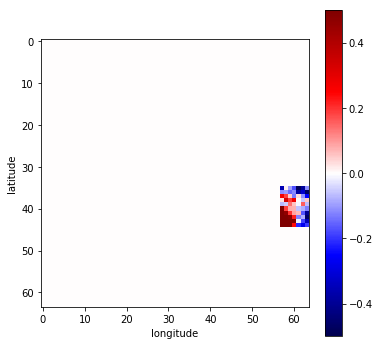

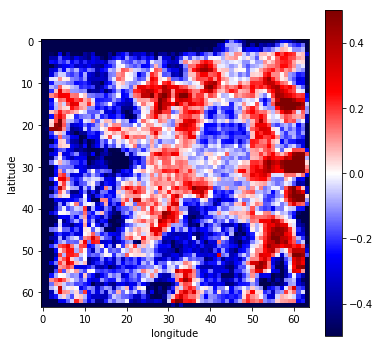

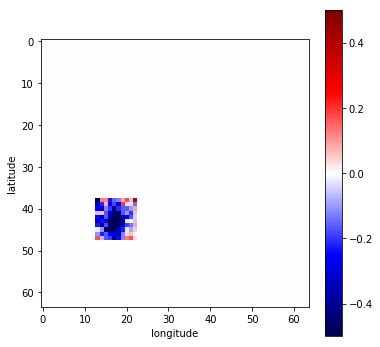

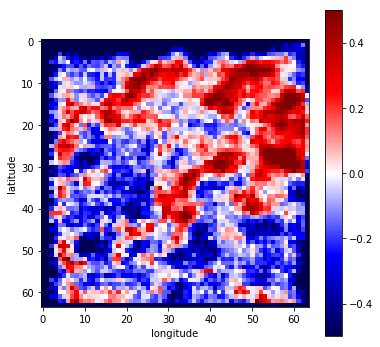

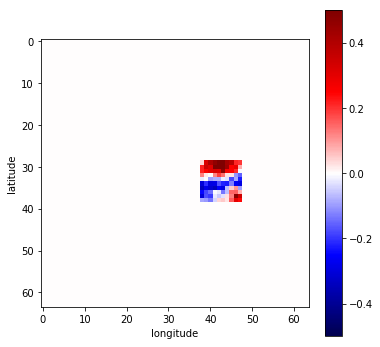

In [59]:
# random plotting indexes
v = [0,6,11]
# plot of differences of y_pred - y_real
for index in v:
    plt.figure(figsize=(6,6))
    plt.imshow(imdiff_1hole1[im_ind+index],vmin=-0.5,vmax=0.5,cmap='seismic')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.colorbar()
    plt.figure(figsize=(6,6))
    plt.imshow(imdiff_1hole12[im_ind+index],vmin=-0.5,vmax=0.5,cmap='seismic')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.colorbar()

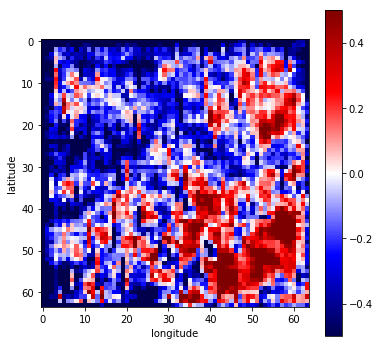

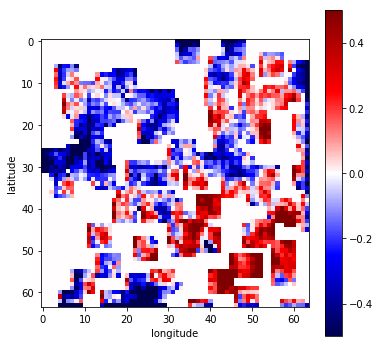

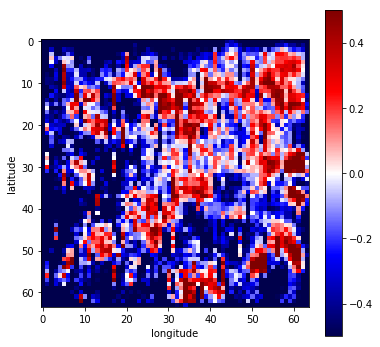

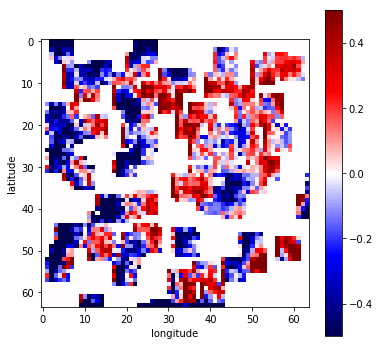

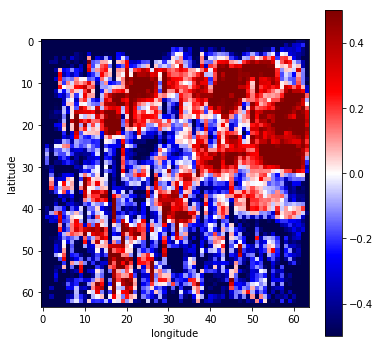

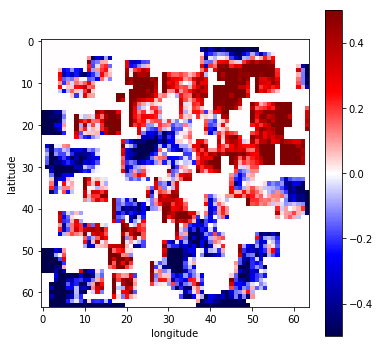

In [60]:
# random plotting indexes
v = [0,6,11]
# plot of differences of y_pred - y_real
for index in v:
    plt.figure(figsize=(6,6))
    plt.imshow(imdiff_nhole2[im_ind+index],vmin=-0.5,vmax=0.5,cmap='seismic')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.colorbar()
# plot of scatter plot of y_inpaint and y_real
    plt.figure(figsize=(6,6))
    plt.imshow(imdiff_nhole22[im_ind+index],vmin=-0.5,vmax=0.5,cmap='seismic')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.colorbar()

# Scatter plots

0.9752460525442291
-0.16714721947517705
0.8546626776523013
0.0644228030475841
0.9553749556710522
-0.07064105570091009


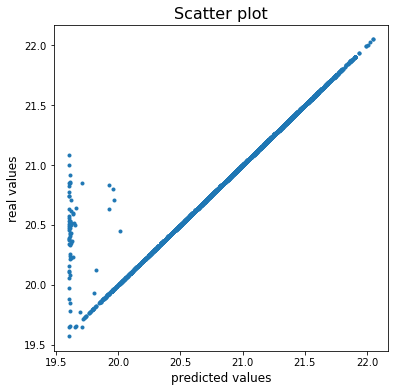

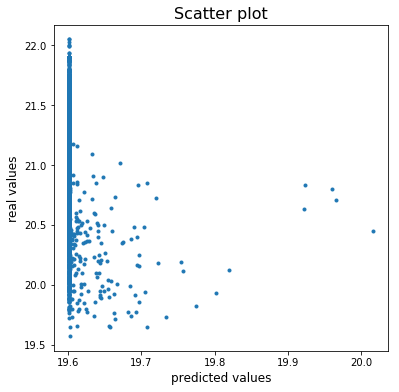

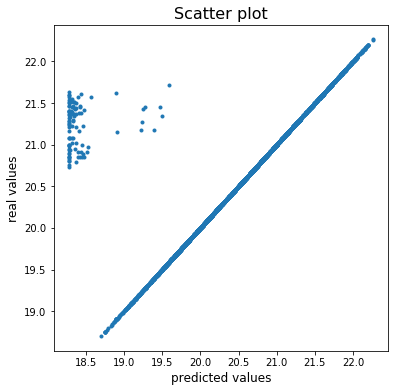

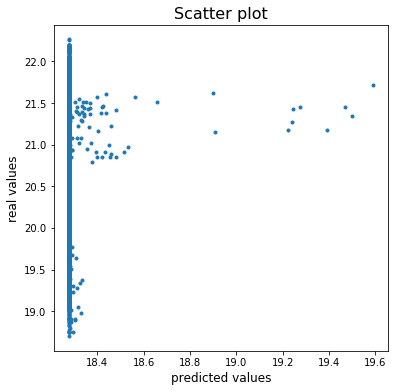

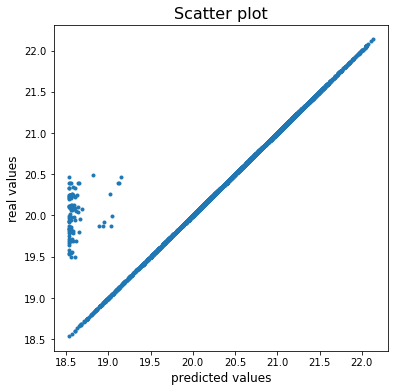

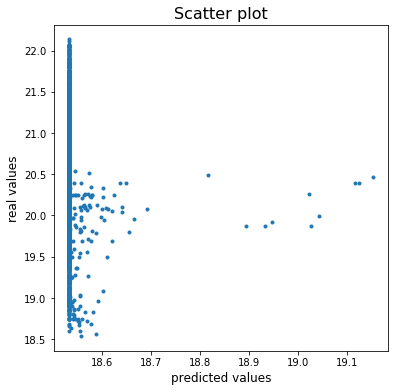

In [61]:
# random plotting indexes
v = [0,6,11]
# plot of scatter plot of y_inpaint and y_real
for index in v:
    plt.figure(figsize=(6,6))
    plt.plot(inpainted2_gan_orig[im_ind+index].reshape(-1,1),xtest_o[im_ind+index].reshape(-1,1),'.')
    plt.title('Scatter plot',fontsize=16)
    plt.xlabel('predicted values',fontsize=12)
    plt.ylabel('real values',fontsize=12)
    print(np.corrcoef(inpainted2_gan_orig[im_ind+index].reshape(-1,1).T,xtest_o[im_ind+index].reshape(-1,1).T)[1,0])
# plot of scatter plot of y_pred and y_real
    plt.figure(figsize=(6,6))
    plt.plot(decoded_imgs_orig5[im_ind+index].reshape(-1,1),xtest_o[im_ind+index].reshape(-1,1),'.')
    plt.title('Scatter plot',fontsize=16)
    plt.xlabel('predicted values',fontsize=12)
    plt.ylabel('real values',fontsize=12)
    print(np.corrcoef(decoded_imgs_orig5[im_ind+index].reshape(-1,1).T,xtest_o[im_ind+index].reshape(-1,1).T)[1,0])


0.8683470927987352
0.6316785606358852
0.9262471653388226
0.7055167444975344
0.8928153701852152
0.6585551269623551


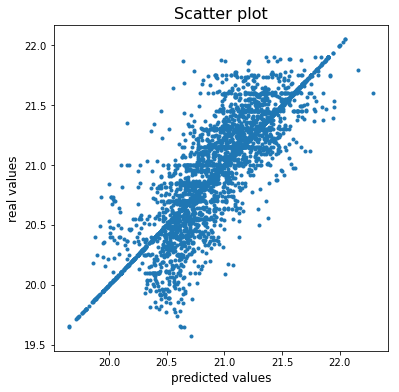

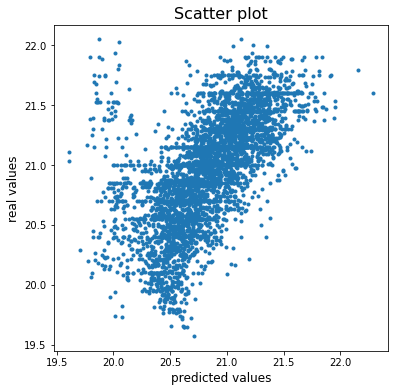

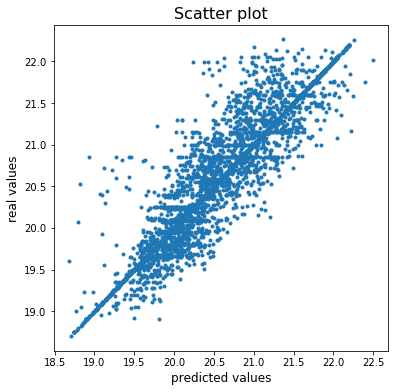

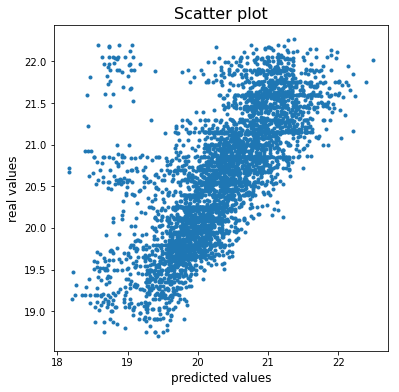

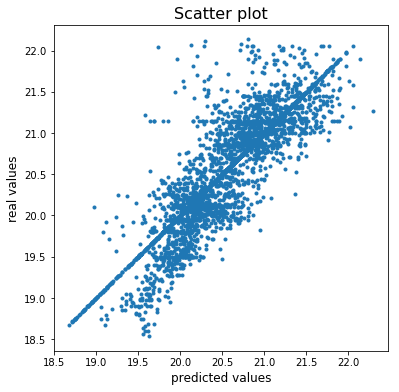

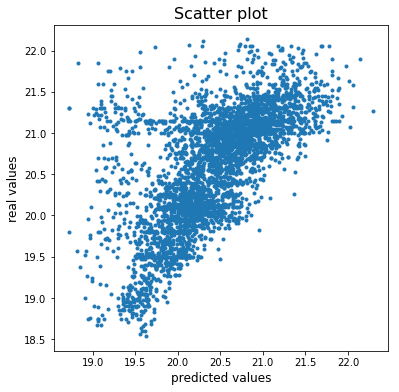

In [62]:
# random plotting indexes
v = [0,6,11]
# plot of scatter plot of y_inpaint and y_real
for index in v:
    plt.figure(figsize=(6,6))
    plt.plot(inpainted3_gan_orig[im_ind+index].reshape(-1,1),xtest_o[im_ind+index].reshape(-1,1),'.')
    plt.title('Scatter plot',fontsize=16)
    plt.xlabel('predicted values',fontsize=12)
    plt.ylabel('real values',fontsize=12)
    print(np.corrcoef(inpainted3_gan_orig[im_ind+index].reshape(-1,1).T,xtest_o[im_ind+index].reshape(-1,1).T)[1,0])
# plot of scatter plot of y_pred and y_real
    plt.figure(figsize=(6,6))
    plt.plot(decoded_imgs_orig6[im_ind+index].reshape(-1,1),xtest_o[im_ind+index].reshape(-1,1),'.')
    plt.title('Scatter plot',fontsize=16)
    plt.xlabel('predicted values',fontsize=12)
    plt.ylabel('real values',fontsize=12)
    print(np.corrcoef(decoded_imgs_orig6[im_ind+index].reshape(-1,1).T,xtest_o[im_ind+index].reshape(-1,1).T)[1,0])
